In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
sns.set()

In [3]:
data  = pd.read_csv('hypothyroid.csv')

In [4]:
data.shape

(3772, 30)

In [5]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


Problem Statement :  To build a classification methodology to predict the type of Thyroid a person has ,based on the below features.

age - Age of the person

sex - Male or Female

on_thyroxine - true or false

on_antithyroid_medication - true or false

sick - true or false

pregnant - true or false

thyroid_surgery - true or false

I131_treatment - true or false

query_hypothyroid - true or false

query_hyperthyroid -true or false

lithium - true or false

goitre - true or false

tumor - true or false

hypopituitary- true or false

psych - true or false

TSH_measured - true or false

TSH - thyroid stimulating hormone floating value

T3_measured - true or false

T3 - triiodothyronine value

TT4_measured- true or false

TT4 - Thyroxine value

T4U_measured- true or false

T4U - numerical value

FTI_measured- true or false

FTI -Free Thyroxine Index

TBG_measured- true or false

TBG -Thyroid-Binding Globulin  value

referral_source - different sources of referals

Class - different types of thyroid

In [6]:
data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,...,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,...,2,242,2,147,2,235,1,1,5,4
top,59,F,f,f,f,f,f,f,f,f,...,t,?,t,?,t,?,f,?,other,negative
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,...,3541,231,3385,387,3387,385,3772,3772,2201,3481


We can see from the data description that there are no missing values. But if you check the dataset the missing values are replaced with invalid values like '?'. Let's replace such values with 'nan' and check for missing values again.

In [7]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        print(column, data[column][data[column]=='?'].count())
    

age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


So these are the columns which have missing values but missing values are replaced with '?'. We will replace these values with 'nan' and then do imputation of these missing values. 

Also, we can see thatfor column 'TBG' all the values are missing. So we will drop this column as it is of no use to us.

In [8]:
data = data.drop(['TBG'],axis =1)

Also, looking to the dataset, we can see that some columns are with true and false value are just the indication that whether the next column has values or not. Let's see an example:

In [9]:
data[['T4U_measured','T4U']] 

,T4U_measured,T4U
0,t,1.14
1,f,?
2,t,0.91
3,f,?
4,t,0.87
...,...,...
3767,f,?
3768,t,1.08
3769,t,1.07
3770,t,0.94


Since, we are any ways going to handle the missing values, there is no point of having such columns in our dataset.

Let's drop such columns as well.

In [10]:
data = data.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'],axis =1)

In [11]:
# Now let's replace the '?' values with numpy nan
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        data[column] = data[column].replace('?',np.nan)    

In [12]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count==0:
        print(column, data[column][data[column]=='?'].count())    

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_medication 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH 0
T3 0
TT4 0
T4U 0
FTI 0
referral_source 0
Class 0


Now that we have replaced all such values with 'nan'. Let's deal with these missing values now.

In [13]:
data.isna().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

Since the values are categorical, we have to change them to numerical before we use any imputation techniques.

We can use get dummies but since most of the columns have only two distinct categories we will use mapping for them. Because since there are only two categories then the two columns formed after get dummies will both have very high correaltion since they both explain the same thing. So in anyway we will have to drop one of the columns. That's why let's use mapping for such columns.
For columns with more than two categories we will use get dummies.

In [14]:
for column in data.columns:
    print(column, (data[column].unique()))

age ['41' '23' '46' '70' '18' '59' '80' '66' '68' '84' '67' '71' '28' '65'
 '42' '63' '51' '81' '54' '55' '60' '25' '73' '34' '78' '37' '85' '26'
 '58' '64' '44' '48' '61' '35' '83' '21' '87' '53' '77' '27' '69' '74'
 '38' '76' '45' '36' '22' '43' '72' '82' '31' '39' '49' '62' '57' '1' '50'
 '30' '29' '75' '19' '7' '79' '17' '24' '15' '32' '47' '16' '52' '33' '13'
 '10' '89' '56' '20' '90' '40' '88' '14' '86' '94' '12' '4' '11' '8' '5'
 '455' '2' '91' '6' nan '93' '92']
sex ['F' 'M' nan]
on_thyroxine ['f' 't']
query_on_thyroxine ['f' 't']
on_antithyroid_medication ['f' 't']
sick ['f' 't']
pregnant ['f' 't']
thyroid_surgery ['f' 't']
I131_treatment ['f' 't']
query_hypothyroid ['f' 't']
query_hyperthyroid ['f' 't']
lithium ['f' 't']
goitre ['f' 't']
tumor ['f' 't']
hypopituitary ['f' 't']
psych ['f' 't']
TSH ['1.3' '4.1' '0.98' '0.16' '0.72' '0.03' nan '2.2' '0.6' '2.4' '1.1' '2.8'
 '3.3' '12' '1.2' '1.5' '6' '2.1' '0.1' '0.8' '1.9' '3.1' '0.2' '13' '0.3'
 '0.035' '2.5' '0.5' '1.7' '7.3'

In [15]:
# We can map the categorical values like below:
data['sex'] = data['sex'].map({'F' : 0, 'M' : 1})

# except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.

for column in data.columns:
    if  len(data[column].unique())==2:
        data[column] = data[column].map({'f' : 0, 't' : 1})
        
# this will map all the rest of the columns as we require. Now there are handful of column left with more than 2 categories. 


In [16]:
data['referral_source'].unique()

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [17]:
# we will use get_dummies with that.
data = pd.get_dummies(data, columns=['referral_source'])

Now our ouptut class also has 4 distinct categories. There is no sense of using get dummies with our Output class, so we will just map them.
Let's use LabelEncoder function for this.

In [18]:
data['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [19]:
lblEn = LabelEncoder()

data['Class'] =lblEn.fit_transform(data['Class'])

In [20]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,...,2.5,125,1.14,109,1,0,1,0,0,0
1,23,0.0,0,0,0,0,0,0,0,0,...,2,102,NaN,NaN,1,0,0,0,0,1
2,46,1.0,0,0,0,0,0,0,0,0,...,NaN,109,0.91,120,1,0,0,0,0,1
3,70,0.0,1,0,0,0,0,0,0,0,...,1.9,175,NaN,NaN,1,0,0,0,0,1
4,70,0.0,0,0,0,0,0,0,0,0,...,1.2,61,0.87,70,1,0,0,0,1,0


In [21]:
data.describe(include='all')

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3771,3622.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3003,3541,3385,3387,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
unique,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69,241,146,234,NaN,NaN,NaN,NaN,NaN,NaN
top,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,101,0.99,100,NaN,NaN,NaN,NaN,NaN,NaN
freq,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238,71,95,73,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.315295,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,NaN,NaN,NaN,NaN,0.974814,0.029692,0.102333,0.010339,0.274125,0.583510
std,NaN,0.464698,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,NaN,NaN,NaN,NaN,0.279508,0.169760,0.303126,0.101169,0.446131,0.493042
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000


Now that we have encoded all our Categorical values. Let's start with imputing the missing values.

In [22]:
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(data) # impute the missing values
    # convert the nd-array returned in the step above to a Dataframe
new_data=pd.DataFrame(data=np.round(new_array), columns=data.columns)

In [23]:
new_data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,51.737275,0.307529,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,2.027306,108.459438,1.020944,110.301166,0.974814,0.029692,0.102333,0.010339,0.274125,0.583510
std,20.082478,0.461532,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,0.785068,34.838114,0.165546,32.145618,0.279508,0.169760,0.303126,0.101169,0.446131,0.493042
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,88.000000,1.000000,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,104.000000,1.000000,107.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,124.000000,1.000000,124.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,455.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,11.000000,430.000000,2.000000,395.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
new_data.isna().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH                          0
T3                           0
TT4                          0
T4U                          0
FTI                          0
Class                        0
referral_source_STMW         0
referral_source_SVHC         0
referral_source_SVHD         0
referral_source_SVI          0
referral_source_other        0
dtype: int64

Great! Now there are no missing values in our new dataset. 


Let's check the distribution for our continous data in the dataset:

C:\ProgramData\Anaconda3\envs\Thyroid_Detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\Thyroid_Detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\Thyroid_Detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

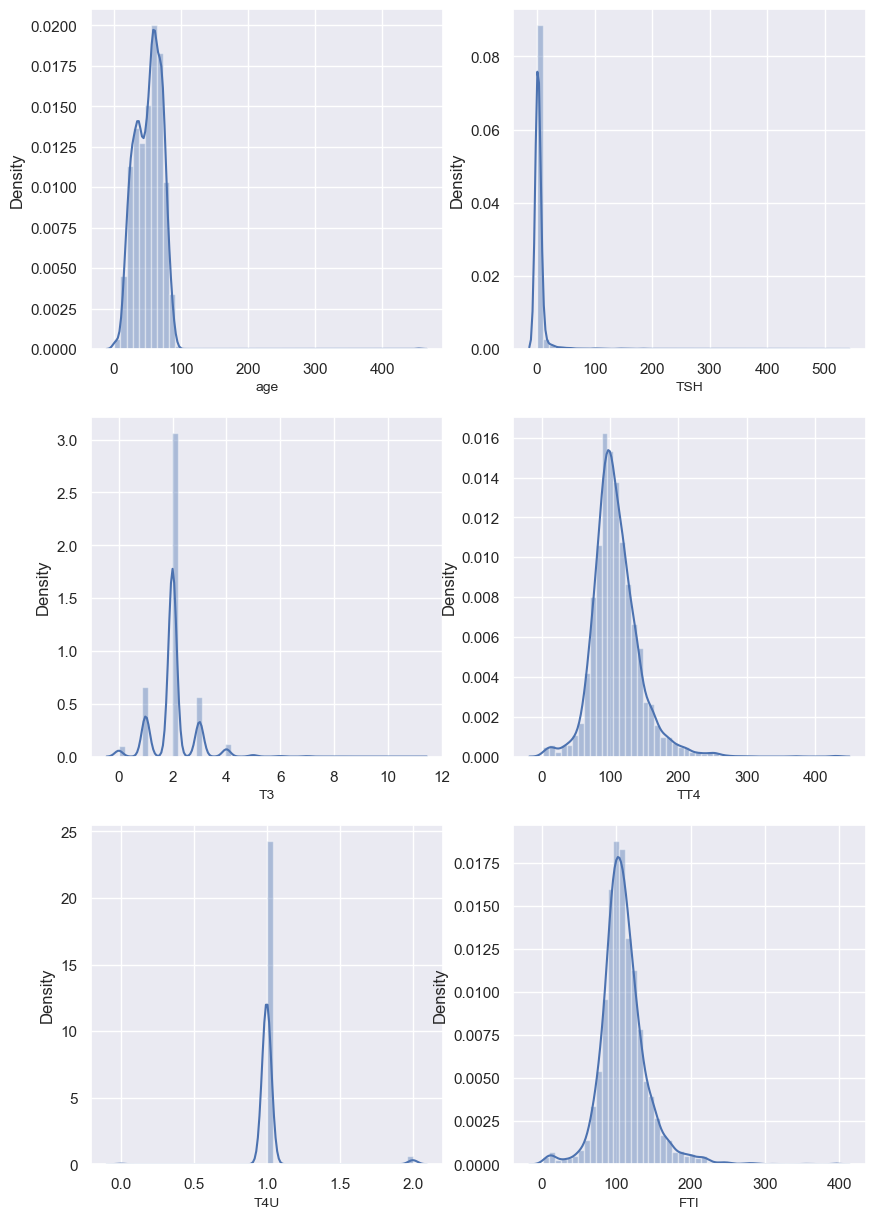

In [25]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plot.subplot(3,2,plotnumber)
    sns.distplot(x=new_data[column])
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()

The graphs for age, TSH and T3 looks heavely skewed towards left. Let's do some transformations to the data and see if it improves the plot.

Before doing log transformation , let's add 1 to each valuue in the column to handle exception when we try to find log of '0'.

C:\ProgramData\Anaconda3\envs\Thyroid_Detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\Thyroid_Detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\Thyroid_Detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

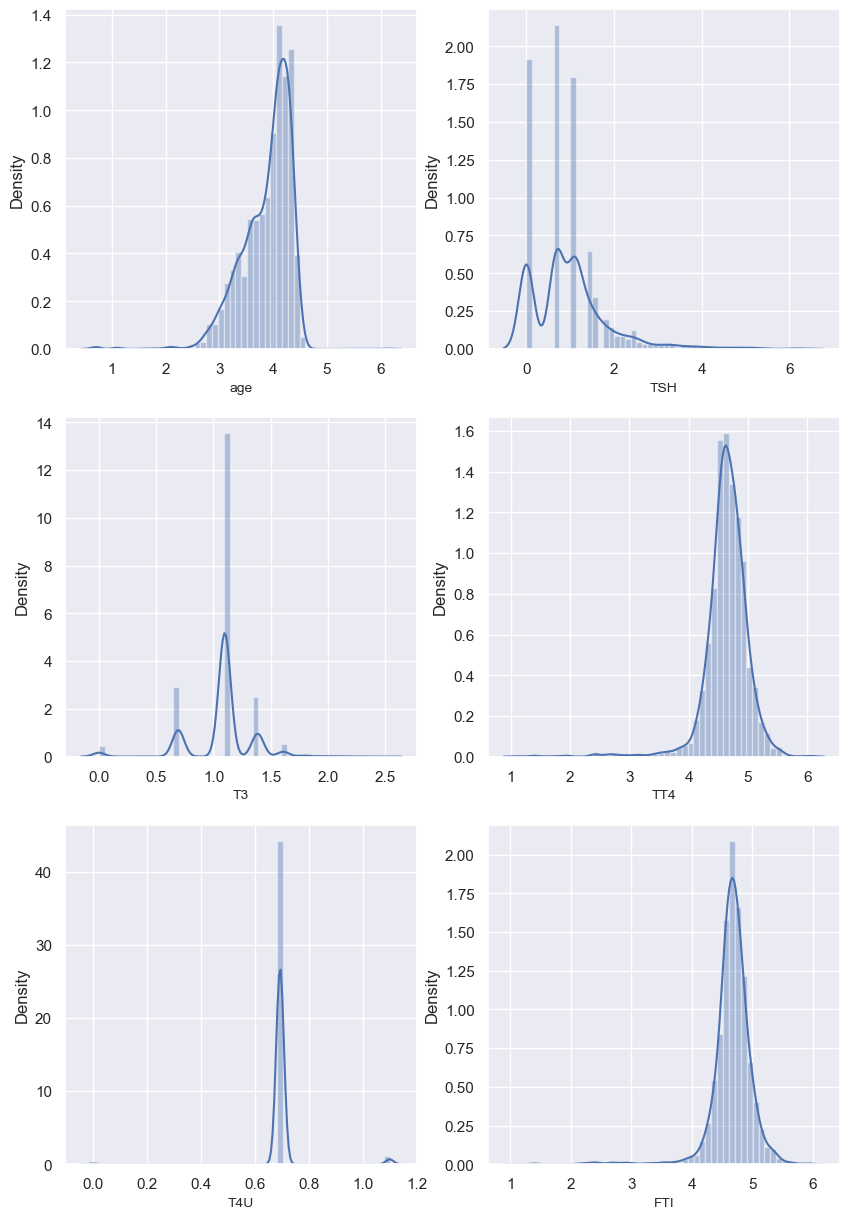

In [26]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    new_data[column]+=1
    ax = plot.subplot(3,2,plotnumber)
    sns.distplot(np.log(new_data[column]))
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()


After log transformation, rest of the columns look fine but 'TSH' has a weird trend.

It won't give much of information so let's drop this column.

In [27]:
new_data = new_data.drop(['TSH'],axis=1)


#### let's see how balanced our dataset in terms of given target classes:

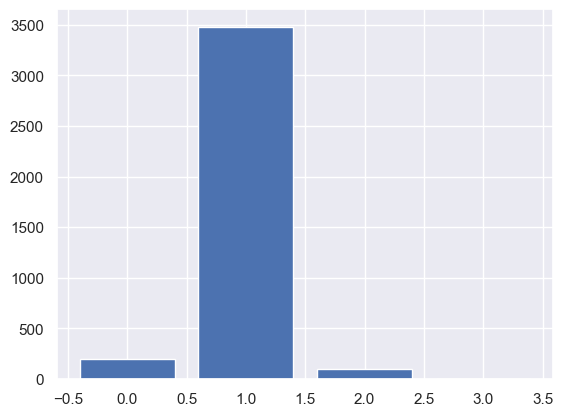

In [28]:
# let's see how data is distributed for every column for every individual id
# the graph plot below is for individual ids. Press 1 in the  input box below the graph to continue viewing graph for each id!!

#plot.figure(figsize=(20,25), facecolor='white')
# plotnumber = 1
# plt_data = data.drop(['age'], axis =1)

# for column in plt_data:
#     ax = plot.subplot(6,5,plotnumber)
#     sns.countplot(plt_data[column])
#     plot.xlabel(column,fontsize=10)
#     plotnumber+=1
# plot.show()

import matplotlib.pyplot as plt
counts = new_data['Class'].value_counts()
plt.bar(counts.index, counts.values)
plt.show() 

#sns.countplot(data = new_data['Class'])
        
    

We can clerly see that the dataset is highly imbalanced. 

We will use a python library known as imbalanced-learn to deal with imbalanced data.
Imbalanced learn has an algorithm called RandomOverSampler. We will use different techniques in another projects. 
You can study more about different techniques below.

Note: https://pypi.org/project/imbalanced-learn/

https://github.com/scikit-learn-contrib/imbalanced-learn


Also, ensemble techniques are well versed in handling such imbalanced data. But for the sake of learning we will see how such issues are dealt with.

In [29]:
x = new_data.drop(['Class'],axis=1)
y = new_data['Class']
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_sample(x,y)

In [30]:
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_sample(x,y)

In [31]:
x_sampled.shape

(13924, 25)

In [32]:
x_sampled = pd.DataFrame(data = x_sampled, columns = x.columns)

In [33]:
x_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0
13920,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
13922,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0


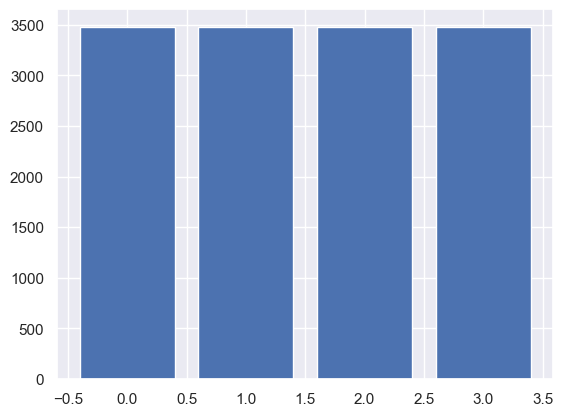

In [34]:
import matplotlib.pyplot as plt
#sns.countplot(data=y_sampled)       
counts = y_sampled.value_counts()
plt.bar(counts.index, counts.values)
plt.show()    

Great! Our dataset looks balanced now. We can go ahead with training our model on this data.

In [35]:
y_sampled.shape

(13924,)

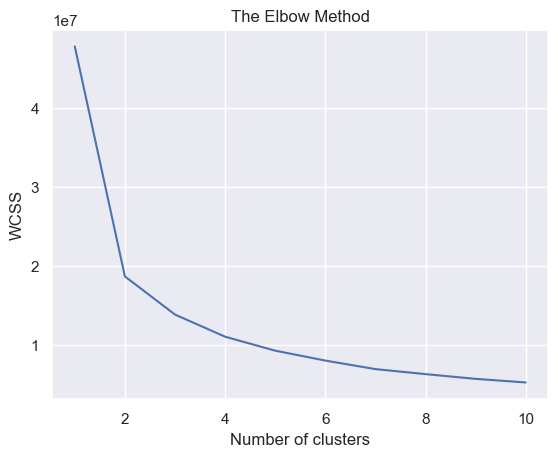

In [36]:
from sklearn.cluster import KMeans

wcss=[] # initializing an empty list
for i in range (1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
    kmeans.fit(x_sampled) # fitting the data to the KMeans Algorithm
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11),wcss) # creating the graph between WCSS and the number of clusters
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [37]:
# finding the value of the optimum cluster programmatically

from kneed import KneeLocator

kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')

In [38]:
number_of_clusters = kn.knee
print("optimum number of clusters",kn.knee)

optimum number of clusters 3


In [39]:
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
y_kmeans=kmeans.fit_predict(x_sampled) #  divide data into clusters

In [40]:
x_sampled.iloc[:,0]

0        42.0
1        24.0
2        47.0
3        71.0
4        71.0
         ... 
13919    42.0
13920    42.0
13921    47.0
13922    47.0
13923    42.0
Name: age, Length: 13924, dtype: float64

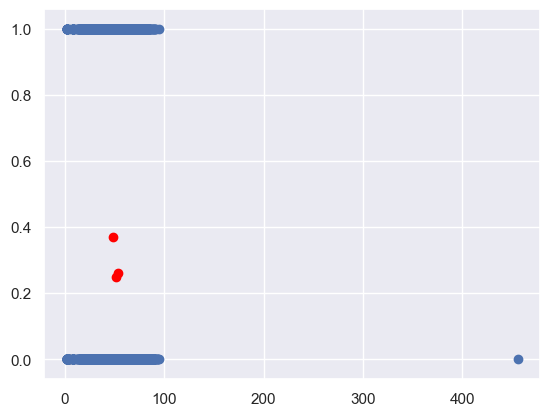

In [41]:
plt.scatter(x_sampled.iloc[:,0], x_sampled.iloc[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red')
plt.show()

In [42]:
x_sampled['Cluster']= y_kmeans  # create a new column in dataset for storing the cluster information

In [43]:
x_sampled.head(10)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Cluster
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0,0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0,1
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0,0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0,0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0,1
5,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,184.0,2.0,142.0,0.0,0.0,0.0,0.0,1.0,0
6,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,73.0,2.0,79.0,0.0,0.0,0.0,0.0,1.0,1
7,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,81.0,2.0,116.0,0.0,0.0,0.0,1.0,0.0,1
8,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,124.0,2.0,133.0,0.0,0.0,0.0,1.0,0.0,0
9,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,84.0,2.0,94.0,0.0,0.0,0.0,1.0,0.0,1


In [44]:
#create a new column in the dataset consisting of the corresponding cluster assignments.
x_sampled['Labels']=y_sampled

In [45]:
# getting the unique clusters from our dataset
list_of_clusters=x_sampled['Cluster'].unique()

print(list_of_clusters)

[0 1 2]


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import roc_auc_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [77]:
def get_best_params_for_random_forest(train_x,train_y):
    try:
        clf = RandomForestClassifier()
        # initializing with different combination of parameters
        param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],"max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}
        
        #Creating an object of the Grid Search class
        grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,  verbose=3)
        
        #finding the best parameters
        grid.fit(train_x, train_y)
        
        #extracting the best parameters
        criterion = grid.best_params_['criterion']
        max_depth = grid.best_params_['max_depth']
        max_features = grid.best_params_['max_features']
        n_estimators = grid.best_params_['n_estimators']
        
        print("criterion = " + str(criterion) + " max_depth = " + str(max_depth) + " max_features = "+ str(max_features) +" n_estimators = "+ str(n_estimators))
        
        #creating a new model with the best parameters
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,max_depth=max_depth, max_features=max_features)
        
        # training the mew model
        clf.fit(train_x, train_y)
            
        return clf
    except Exception as e:
        raise Exception()

In [78]:
 def get_best_params_for_KNN(train_x, train_y):
        try:
            knn = KNeighborsClassifier()
            # initializing with different combination of parameters
            param_grid_knn = {
                'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                'leaf_size' : [10,17,24,28,30,35],
                'n_neighbors':[4,5,8,10,11],
                'p':[1,2]
            }

            # Creating an object of the Grid Search class
            grid = GridSearchCV(knn, param_grid_knn, verbose=3,cv=5)
            
            # finding the best parameters
            grid.fit(train_x, train_y)

            # extracting the best parameters
            algorithm = grid.best_params_['algorithm']
            leaf_size = grid.best_params_['leaf_size']
            n_neighbors = grid.best_params_['n_neighbors']
            p  = grid.best_params_['p']

            print("algorithm = " + str(algorithm) + " leaf_size = " + str(leaf_size) + " n_neighbors = " + str(n_neighbors) + " p = " + str(p))
            
            # creating a new model with the best parameters
            knn = KNeighborsClassifier(algorithm=algorithm, leaf_size=leaf_size, n_neighbors=n_neighbors,p=p,n_jobs=-1)
            
            # training the mew model
            knn.fit(train_x, train_y)
            
            return knn
        except Exception as e:
            raise Exception()

In [79]:
def get_best_model(train_x,train_y,test_x,test_y):
    # create best model for KNN
    try:
        knn= get_best_params_for_KNN(train_x,train_y)
        
        # Predictions using the KNN Model
        prediction_knn = knn.predict_proba(test_x) 
        
        #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
        if len(test_y.unique()) == 1: 
            knn_score = accuracy_score(test_y, prediction_knn)
            print("knn accuracy = "+ str(knn_score))
        else:
            knn_score = roc_auc_score(test_y, prediction_knn, multi_class='ovr') # AUC for KNN
            print("knn roc_auc_score = "+ str(knn_score))

        # create best model for Random Forest
        random_forest=get_best_params_for_random_forest(train_x,train_y)
        prediction_random_forest=random_forest.predict_proba(test_x) 
        
        # prediction using the Random Forest Algorithm
        if len(test_y.unique()) == 1:
            #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
            random_forest_score = accuracy_score((test_y),prediction_random_forest)
            print("random_forest_score accuracy_score = "+ str(random_forest_score))
        else:
            random_forest_score = roc_auc_score((test_y), prediction_random_forest,multi_class='ovr') # AUC for Random Forest
            print("random_forest_score roc_auc_score = "+ str(random_forest_score))
            
        #comparing the two models
        if(random_forest_score <  knn_score):
            return 'KNN',knn
        else:
            return 'RandomForest',random_forest

    except Exception as e:
        raise Exception()

In [80]:
model_directory='models/'
def save_model(model,filename):
    try:
        #create seperate directory for each cluster
        path = os.path.join(model_directory,filename) 
            
        #remove previously existing models for each clusters
        if os.path.isdir(path): 
            shutil.rmtree(model_directory)
            os.makedirs(path)
        else:
            os.makedirs(path) 
        with open(path +'/' + filename+'.sav','wb') as f:
            # save the model to file
            pickle.dump(model, f) 

        return 'success'
    except Exception as e:
        raise Exception()

In [81]:
 def load_model(filename):
        try:
            with open(model_directory + filename + '/' + filename + '.sav','rb') as f:
                return pickle.load(f)
        except Exception as e:
            raise Exception()

In [82]:
def find_correct_model_file(cluster_number):
    try:
        cluster_number= cluster_number
        folder_name=model_directory
        list_of_model_files = []
        list_of_files = os.listdir(folder_name)
        for file in list_of_files:
            try:
                if (file.index(str(cluster_number))!=-1):
                    model_name=file
            except:
                continue
            model_name=model_name.split('.')[0]
            return model_name
    except Exception as e:
        raise Exception()

In [83]:
from sklearn.model_selection import train_test_split
import pickle
import os
import shutil

#parsing all the clusters and looking for the best ML algorithm to fit on individual cluster
a=1
model_directory='models/'
for i in list_of_clusters:
    
    # filter the data for one cluster
    cluster_data=x_sampled[x_sampled['Cluster']==i] 

    # Prepare the feature and Label columns
    cluster_features=cluster_data.drop(['Labels','Cluster'],axis=1)
    cluster_label= cluster_data['Labels']

    # splitting the data into training and test set for each cluster one by one
    x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=1 / 3, random_state=355)

    #getting the best model for each of the clusters
    best_model_name,best_model = get_best_model(x_train,y_train,x_test,y_test)

    #saving the best model to the directory.
    
    model_num = "% s" % a
    a=a+1
    best_model_name = best_model_name+model_num
    #save_model=save_model(best_model,best_model_name)
    path = os.path.join(model_directory,best_model_name) 
    #remove previously existing models for each clusters
    if os.path.isdir(path): 
        shutil.rmtree(model_directory)
        os.makedirs(path)
    else:
        os.makedirs(path) 
    with open(path +'/' + best_model_name+'.sav','wb') as f:
        # save the model to file
        pickle.dump(best_model, f) 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.889, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.938, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.923, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.920, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.886, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.90

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.889, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.938, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.923, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.920, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, score=0.886, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=2, score=0.902, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_nei

[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1, score=0.883, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1, score=0.877, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1, score=0.840, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2, score=0.852, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2, score=0.895, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2, score=0.867, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_nei

[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1, score=0.825, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1, score=0.868, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1, score=0.864, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1, score=0.858, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1, score=0.824, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=2, score=0.831, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=24,

[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=10, p=2, score=0.858, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=10, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=10, p=2, score=0.827, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1, score=0.812, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1, score=0.871, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1, score=0.864, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1, score=0.852, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=28,

[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2, score=0.877, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2, score=0.846, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2, score=0.846, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2, score=0.818, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1, score=0.892, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1, score=0.932, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n

[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=1, score=0.877, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2, score=0.902, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2, score=0.948, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2, score=0.917, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2, score=0.926, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2, score=0.895, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1,

[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1, score=0.938, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1, score=0.920, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1, score=0.914, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1, score=0.880, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2, score=0.902, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2, score=0.945, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2,

[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1, score=0.873, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1, score=0.836, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2, score=0.849, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2, score=0.895, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2, score=0.867, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2, score=0.880, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2,

[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2, score=0.831, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2, score=0.877, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2, score=0.843, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2, score=0.858, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2, score=0.827, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1, score=0.812, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=1

[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2, score=0.874, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2, score=0.846, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2, score=0.846, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2, score=0.818, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1, score=0.898, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1, score=0.935, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, 

[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2, score=0.818, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=1, score=0.886, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=1, score=0.929, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=1, score=0.914, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=1, score=0.914, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=1, score=0.880, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=2, score=0.90

[CV]  algorithm=brute, leaf_size=17, n_neighbors=4, p=2, score=0.926, total=   0.0s
[CV] algorithm=brute, leaf_size=17, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=4, p=2, score=0.895, total=   0.0s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.886, total=   0.0s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.926, total=   0.0s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.920, total=   0.0s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.914, total=   0.0s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.880, 

[CV] algorithm=brute, leaf_size=24, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=5, p=2, score=0.917, total=   0.0s
[CV] algorithm=brute, leaf_size=24, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=5, p=2, score=0.926, total=   0.0s
[CV] algorithm=brute, leaf_size=24, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=5, p=2, score=0.895, total=   0.0s
[CV] algorithm=brute, leaf_size=24, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=8, p=1, score=0.837, total=   0.0s
[CV] algorithm=brute, leaf_size=24, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=8, p=1, score=0.880, total=   0.0s
[CV] algorithm=brute, leaf_size=24, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=8, p=1, score=0.880, total=   0.0s
[CV] algorithm=brute, leaf_size=24, n_neighbors=8, p=1 ...............

[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=1, score=0.833, total=   0.0s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=2, score=0.849, total=   0.0s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=2, score=0.895, total=   0.0s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=2, score=0.864, total=   0.0s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=2, score=0.883, total=   0.0s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=2, score=0.852, total=   0.0s
[CV] algorithm=brute, leaf_size=28, n_neighbors=10, p=1 ..............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=10, p=1, score=0.831,

[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=1, score=0.815, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=2, score=0.831, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=2, score=0.877, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=2, score=0.840, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=2, score=0.864, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=2, score=0.824, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=11, p=1 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=11, p=1, score=

[CV]  algorithm=brute, leaf_size=35, n_neighbors=11, p=1, score=0.812, total=   0.0s
[CV] algorithm=brute, leaf_size=35, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=11, p=2, score=0.815, total=   0.0s
[CV] algorithm=brute, leaf_size=35, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=11, p=2, score=0.874, total=   0.0s
[CV] algorithm=brute, leaf_size=35, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=11, p=2, score=0.846, total=   0.0s
[CV] algorithm=brute, leaf_size=35, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=11, p=2, score=0.852, total=   0.0s
[CV] algorithm=brute, leaf_size=35, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=11, p=2, score=0.818, total=   0.0s
algorithm = ball_tree leaf_size = 17 n_neighbors = 4 p = 2


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   19.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


knn roc_auc_score = 0.9906042897372377
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.686, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.686, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.685, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.685, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.685, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n

[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.685, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.698, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.686, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.685, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.685, total=   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.685, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto,

[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.685, total=   0.2s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.685, total=   0.2s
[CV] criterion=entropy, max_depth=2, max_features=auto, n_estimators=130 
[CV]  criterion=entropy, max_depth=2, max_features=auto, n_estimators=130, score=0.685, total=   0.2s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.686, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.686, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=10, score=0.685, total=   0.0s
[CV] criterion=entropy, 

[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.702, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.685, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.685, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.685, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.686, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.686, total=   0.1s
[CV] criterion=entropy, m

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   17.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.879, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.872, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.895, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.848, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.895, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.879, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_nei

[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2, score=0.879, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2, score=0.879, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1, score=0.895, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1, score=0.847, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1, score=0.901, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1, score=0.882, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_nei

[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.898, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.850, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.898, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.879, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.874, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2, score=0.894, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_nei

[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2, score=0.848, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2, score=0.898, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2, score=0.880, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2, score=0.879, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1, score=0.853, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1, score=0.798, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_nei

[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1, score=0.834, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1, score=0.827, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1, score=0.811, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=2, score=0.844, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=2, score=0.798, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=2, score=0.848, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_nei

[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2, score=0.798, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2, score=0.848, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2, score=0.832, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2, score=0.817, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1, score=0.835, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1, score=0.774, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=35, n_n

[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1, score=0.829, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1, score=0.775, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1, score=0.809, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1, score=0.813, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1, score=0.796, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2, score=0.819, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=1

[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2, score=0.822, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2, score=0.814, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2, score=0.787, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1, score=0.821, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1, score=0.774, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1, score=0.816, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=1

[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=1, score=0.777, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=1, score=0.811, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=1, score=0.817, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=1, score=0.792, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=2, score=0.810, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=2, score=0.767, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=1

[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2, score=0.810, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2, score=0.767, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2, score=0.826, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2, score=0.811, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2, score=0.787, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1, score=0.898, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4,

[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2, score=0.787, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1, score=0.898, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1, score=0.847, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1, score=0.900, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1, score=0.872, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=1, score=0.882, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=2

[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=2, score=0.894, total=   0.1s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=2, score=0.850, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=2, score=0.895, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=2, score=0.877, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=2, score=0.880, total=   0.1s
[CV] algorithm=brute, leaf_size=10, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=5, p=1, score=0.885, total=   0.1s
[CV] algorithm=brute, leaf_size=10, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=5, p=1, score=0.851, 

[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.851, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.887, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.877, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=1, score=0.863, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=2, score=0.894, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=2, score=0.853, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=5, p=2, score=0.898, 

[CV]  algorithm=brute, leaf_size=24, n_neighbors=5, p=2, score=0.853, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=5, p=2, score=0.898, total=   0.0s
[CV] algorithm=brute, leaf_size=24, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=5, p=2, score=0.877, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=5, p=2, score=0.880, total=   0.0s
[CV] algorithm=brute, leaf_size=24, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=8, p=1, score=0.852, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=8, p=1, score=0.800, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=8, p=1, score=0.838, 

[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=1, score=0.800, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=1, score=0.838, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=1, score=0.832, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=1, score=0.813, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=2, score=0.844, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=2, score=0.792, total=   0.0s
[CV] algorithm=brute, leaf_size=28, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=8, p=2, score=0.851, 

[CV]  algorithm=brute, leaf_size=30, n_neighbors=8, p=2, score=0.792, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=8, p=2, score=0.851, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=8, p=2, score=0.832, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=8, p=2 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=8, p=2, score=0.821, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=10, p=1 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=1, score=0.832, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=10, p=1 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=1, score=0.777, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=10, p=1 ..............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=10, p=1, score=0.80

[CV]  algorithm=brute, leaf_size=35, n_neighbors=10, p=1, score=0.805, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=10, p=1 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=10, p=1, score=0.816, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=10, p=1 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=10, p=1, score=0.800, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=10, p=2, score=0.819, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=10, p=2, score=0.769, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=10, p=2, score=0.821, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=10, p=2 ..............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=10, p=2, score=

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   42.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


knn roc_auc_score = 0.9666711235380303
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.608, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.612, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.620, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.627, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.609, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.613, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.611, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.633, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.622, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.601, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.615, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_e

[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.702, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.698, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.679, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.659, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.664, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.698, total=   0.0s
[CV] criterion=gini, max_depth=3, max_features=log2,

[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.624, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.586, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.617, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.591, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.611, total=   0.2s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.601, total=   0.2s
[CV] criterion=entropy, m

[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.654, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.638, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.695, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.670, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.643, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.679, total=   0.2s
[CV] criterion=ent

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   19.5s finished


criterion = gini max_depth = 3 max_features = auto n_estimators = 130
random_forest_score roc_auc_score = 0.878266108524862
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.995, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.995, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=1, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.995, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.995, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2, score=0.995, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=10, n_nei

[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2, score=0.995, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2, score=0.995, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=17, n_nei

[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=24, n_nei

[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2, score=0.993, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=2, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=28, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=28, n_nei

[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=2, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=2, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1, score=0.993, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1, score=0.991, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=30, n_nei

[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=1, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=1, score=0.991, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=1, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=35, n_nei

[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1

[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=8, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1, score=0.993, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1, score=0.991, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=17, n_neighbors=10

[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2, score=0.991, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2, score=0.991, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=10, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=24, n_neighbors=1

[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=10, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1, score=0.993, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1, score=0.991, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=28, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=28, n_neighbors=1

[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1, score=0.991, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2, score=0.993, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2, score=0.991, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=1

[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2, score=0.993, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2, score=0.992, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2, score=0.991, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2, score=0.991, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=1, score=0.995, total=   0.1s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, p=1

[CV]  algorithm=brute, leaf_size=10, n_neighbors=11, p=2, score=0.991, total=   0.1s
[CV] algorithm=brute, leaf_size=10, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=10, n_neighbors=11, p=2, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=4, p=1, score=0.995, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=4, p=1, score=0.995, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=4, p=1, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=4, p=1, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=17, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=17, n_neighbors=4, p=1, score=0.992

[CV]  algorithm=brute, leaf_size=24, n_neighbors=4, p=1, score=0.995, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=4, p=1, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=4, p=1, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=4, p=1 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=4, p=1, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=4, p=2, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=4, p=2, score=0.995, total=   0.1s
[CV] algorithm=brute, leaf_size=24, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=24, n_neighbors=4, p=2, score=0.995, 

[CV]  algorithm=brute, leaf_size=28, n_neighbors=4, p=2, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=4, p=2, score=0.995, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=4, p=2, score=0.995, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=4, p=2, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=4, p=2 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=4, p=2, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=5, p=1, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=28, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=28, n_neighbors=5, p=1, score=0.993, 

[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, p=1, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, p=1, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, p=1, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, p=1, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, p=1 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, p=1, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, p=2, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, p=2, score=0.993, 

[CV]  algorithm=brute, leaf_size=35, n_neighbors=5, p=1, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=5, p=2, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=5, p=2, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=5, p=2, score=0.993, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=5, p=2, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=5, p=2, score=0.992, total=   0.1s
[CV] algorithm=brute, leaf_size=35, n_neighbors=8, p=1 ...............
[CV]  algorithm=brute, leaf_size=35, n_neighbors=8, p=1, score=0.993, 

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.956, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.975, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.947, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.894, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=10, score=0.981, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.974, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_es

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.975, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.974, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.970, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=50 .
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=50, score=0.969, total=   0.1s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.970, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=2, max_features=auto, n_estimators=100, score=0.967, total=   0.2s
[CV] criterion=gini, max_depth=2, max_features=auto, n_

[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.974, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.975, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.976, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.970, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=130 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=130, score=0.976, total=   0.2s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=10 .
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.974, total=   0.0s
[CV] criterion=gini, max_depth=3, max_features=log2,

[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.957, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.965, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.976, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.967, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=50 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=50, score=0.948, total=   0.1s
[CV] criterion=entropy, max_depth=2, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, max_features=log2, n_estimators=100, score=0.949, total=   0.2s
[CV] criterion=entropy, max

[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.970, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.976, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.974, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.975, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.976, total=   0.2s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=130 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=130, score=0.970, total=   0.2s
[CV] criterion=ent

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   20.7s finished
